In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns', None)

print("--- 1. Data Loading (FINAL ATTEMPT: Read as Excel) ---")

file_name = "airbnb_data.csv"
df = None

try:
    df = pd.read_excel(file_name) 
    
    print("Dataset loaded successfully as an Excel/XLSX file.")
    print(f"Total rows loaded: {len(df)}")
    print("\nInitial Data Preview (Head):")
    print(df.head())
    
except Exception as e:
    print(f"FATAL ERROR: Could not load the dataset: {e}")
    df = None

--- 1. Data Loading (FINAL ATTEMPT: Read as Excel) ---
Dataset loaded successfully as an Excel/XLSX file.
Total rows loaded: 102599

Initial Data Preview (Head):
        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4              

In [15]:
if df is not None:
    print("\n--- 2. Data Cleaning and Preprocessing ---")

    # Standardize column names (replace spaces with underscores for easier coding)
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    df = df.rename(columns={'neighbourhood_group': 'neighbourhood_group'})
    
    # --- Clean Price and Service Fee Columns ---
    # Convert 'price' and 'service_fee' to numeric (handling potential commas/currency symbols if any, though the snippet suggests integer values)
    # The snippet suggests price/fee are stored as integers, so we'll fill NaN/missing values for safety and convert to integers later.
    
    # For robust calculation, fill missing numerical columns with the median (or 0 if appropriate, for simplicity in EDA)
    # We will assume NaN in review columns means 0 reviews for simplicity.
    df['number_of_reviews'] = df['number_of_reviews'].fillna(0)
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
    df['review_rate_number'] = df['review_rate_number'].fillna(df['review_rate_number'].median())

    # Fill missing 'Construction_year' with the median year (or mode, depending on distribution).
    # Since the goal is EDA and not high-accuracy ML, simple imputation is okay.
    df['construction_year'] = df['construction_year'].fillna(df['construction_year'].mode()[0]).astype(int)

    # Clean categorical variable 'host_identity_verified'
    df['host_identity_verified'] = df['host_identity_verified'].fillna('unconfirmed').str.lower().str.strip()

    # Clean 'price' and 'service_fee' (handling missing values by removing rows where both are missing, otherwise keep existing values for calculation)
    df.dropna(subset=['price', 'service_fee'], how='all', inplace=True) 

    # Clean categorical column naming: 'room type' -> 'room_type'
    df = df.rename(columns={'room_type': 'room_type'})
    
    # Convert categorical data to consistent format
    for col in ['neighbourhood_group', 'room_type']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower().str.strip()
    
    print("Data cleaning complete. Ready for analysis.")



--- 2. Data Cleaning and Preprocessing ---
Data cleaning complete. Ready for analysis.


In [16]:
if df is not None:
    print("\n--- 3. Exploratory Data Analysis (EDA) - Original Questions ---")

    # 1. What are the different property/room types in the Dataset?
    print("\nQuestion 1: Different Property (Room) Types")
    property_types = df['room_type'].unique()
    print(f"Unique Room Types: {property_types}")



--- 3. Exploratory Data Analysis (EDA) - Original Questions ---

Question 1: Different Property (Room) Types
Unique Room Types: ['private room' 'entire home/apt' 'shared room' 'hotel room']


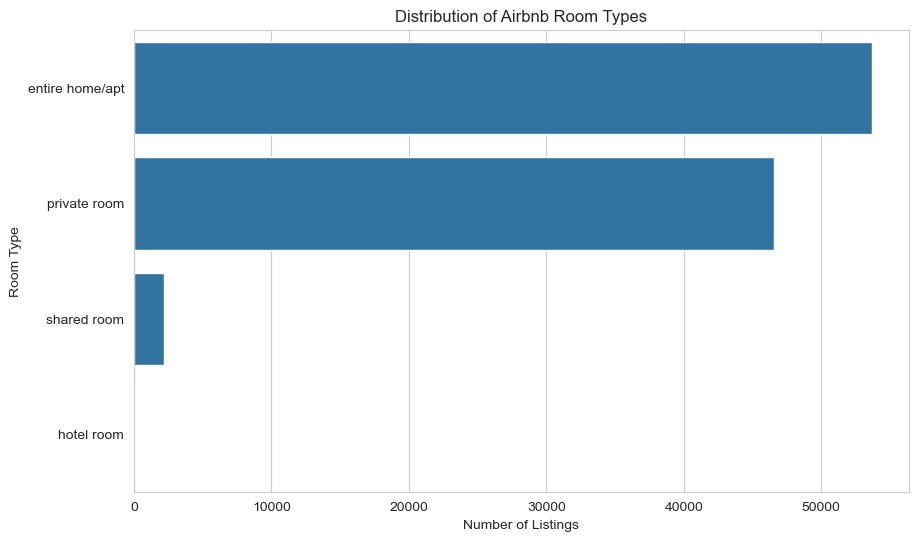

In [20]:
    # Visualization for Question 1
    plt.figure(figsize=(10, 6))
    sns.countplot(y='room_type', data=df, order=df['room_type'].value_counts().index)
    plt.title('Distribution of Airbnb Room Types')
    plt.xlabel('Number of Listings')
    plt.ylabel('Room Type')
    plt.show()


In [21]:
    # 2. Which neighborhood group has the highest number of listings?
    print("\nQuestion 2: Neighborhood Group with Highest Number of Listings")
    top_listings = df['neighbourhood_group'].value_counts().head(5)
    print(top_listings)
    



Question 2: Neighborhood Group with Highest Number of Listings
neighbourhood_group
manhattan        43779
brooklyn         41825
queens           13265
bronx             2711
staten island      954
Name: count, dtype: int64


C:\Users\srdat\AppData\Local\Temp\ipykernel_16648\3209946115.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_listings.index, y=top_listings.values, palette="viridis")


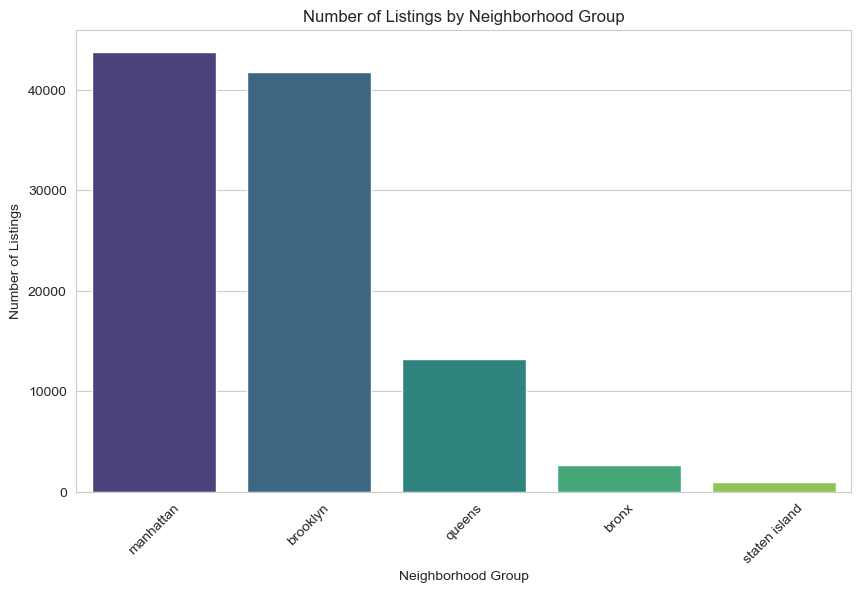

In [22]:
    # Visualization for Question 2
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_listings.index, y=top_listings.values, palette="viridis")
    plt.title('Number of Listings by Neighborhood Group')
    plt.xlabel('Neighborhood Group')
    plt.ylabel('Number of Listings')
    plt.xticks(rotation=45)
    plt.show()

In [24]:
    # 3. Which neighborhood group has the highest average prices for Airbnb listings?
    print("\nQuestion 3: Neighborhood Group with Highest Average Price")
    # Clean up non-numeric values in 'price' for robust calculation
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    
    average_price = df.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False).head(5)
    print(average_price)


Question 3: Neighborhood Group with Highest Average Price
neighbourhood_group
nan              658.357143
queens           630.207647
bronx            627.766359
brooklyn         626.562193
staten island    624.490546
Name: price, dtype: float64


C:\Users\srdat\AppData\Local\Temp\ipykernel_16648\421426761.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_price.index, y=average_price.values, palette="mako")


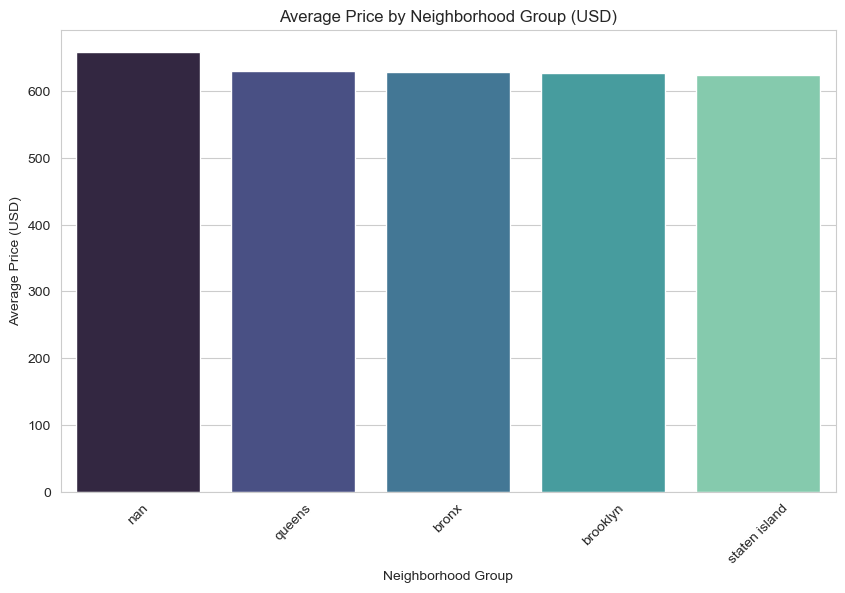

In [25]:
    # Visualization for Question 3
    plt.figure(figsize=(10, 6))
    sns.barplot(x=average_price.index, y=average_price.values, palette="mako")
    plt.title('Average Price by Neighborhood Group (USD)')
    plt.xlabel('Neighborhood Group')
    plt.ylabel('Average Price (USD)')
    plt.xticks(rotation=45)
    plt.show()

In [26]:
    # 4. Is there a relationship between the construction year of property and price?
    print("\nQuestion 4: Relationship between Construction Year and Price")
    # Group by Construction Year and calculate median price to avoid outlier distortion
    price_by_year = df.groupby('construction_year')['price'].median()



Question 4: Relationship between Construction Year and Price


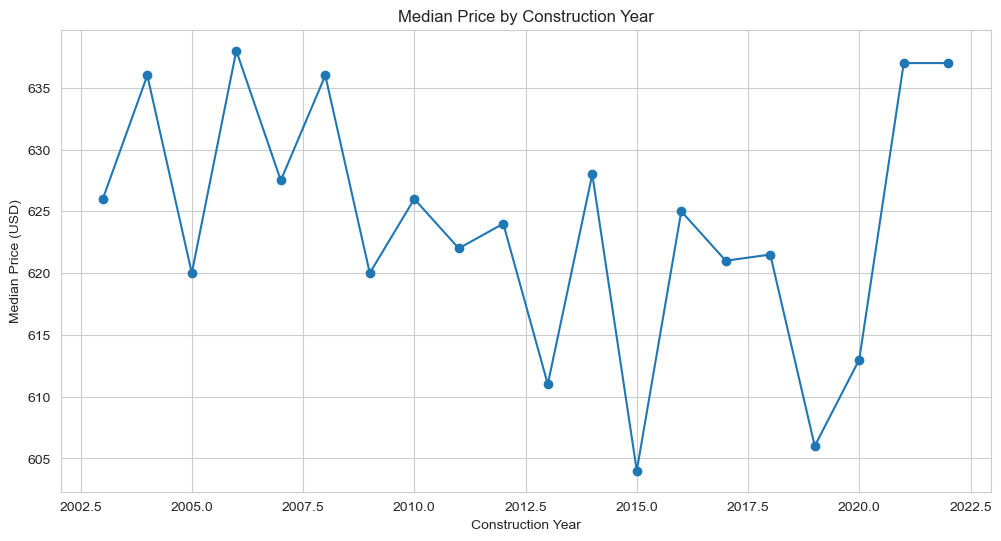

Correlation between Construction Year and Price: -0.0038


In [28]:
    # Visualization for Question 4
    plt.figure(figsize=(12, 6))
    plt.plot(price_by_year.index, price_by_year.values, marker='o', linestyle='-')
    plt.title('Median Price by Construction Year')
    plt.xlabel('Construction Year')
    plt.ylabel('Median Price (USD)')
    plt.show()
    # Calculate correlation coefficient
    correlation = df['construction_year'].corr(df['price'])
    print(f"Correlation between Construction Year and Price: {correlation:.4f}")


Question 5: Top 10 Hosts by Calculated Host Listing Count
        host_name  calculated_host_listings_count
64830  Blueground                           332.0
64894  Blueground                           332.0
57424  Blueground                           332.0
57898  Blueground                           332.0
65480  Blueground                           332.0
66121  Blueground                           332.0
66185  Blueground                           332.0
66258  Blueground                           332.0
64991  Blueground                           332.0
65945  Blueground                           332.0


C:\Users\srdat\AppData\Local\Temp\ipykernel_16648\4252714718.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='calculated_host_listings_count', y='host_name', data=top_hosts, palette='rocket')


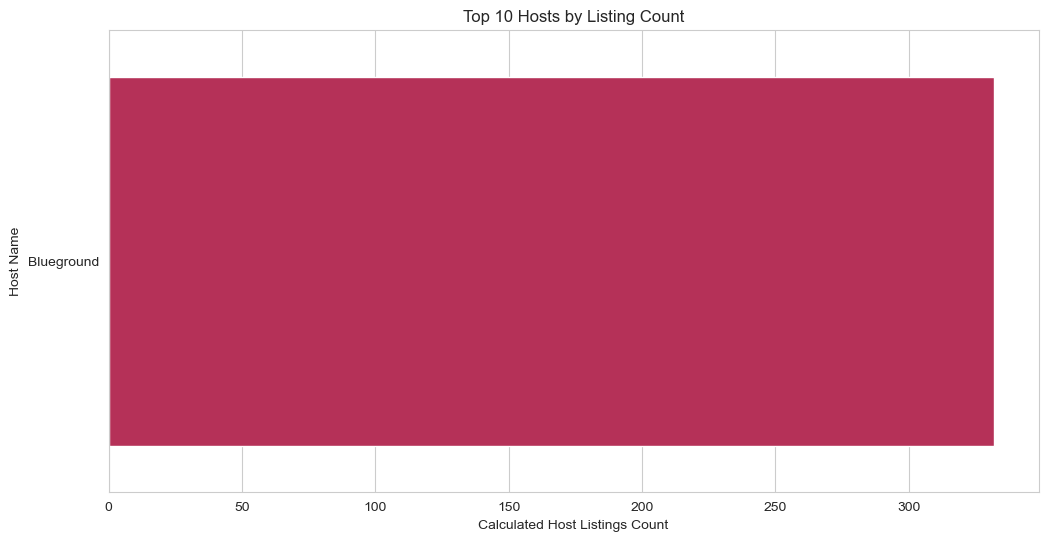


Question 6: Verified Hosts and Review Rate
host_identity_verified
verified       3.286025
unconfirmed    3.270617
Name: review_rate_number, dtype: float64


C:\Users\srdat\AppData\Local\Temp\ipykernel_16648\4252714718.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=review_by_verification.index, y=review_by_verification.values, palette='pastel')


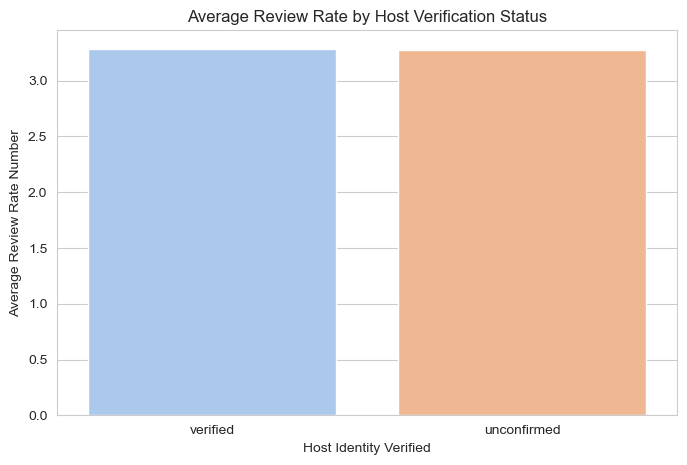

In [29]:
    # 5. Who are the top 10 hosts by calculated host listing count?
    print("\nQuestion 5: Top 10 Hosts by Calculated Host Listing Count")
    top_hosts = df.sort_values(by='calculated_host_listings_count', ascending=False).drop_duplicates(subset=['host_id']).head(10)
    print(top_hosts[['host_name', 'calculated_host_listings_count']])
    
    # Visualization for Question 5
    plt.figure(figsize=(12, 6))
    sns.barplot(x='calculated_host_listings_count', y='host_name', data=top_hosts, palette='rocket')
    plt.title('Top 10 Hosts by Listing Count')
    plt.xlabel('Calculated Host Listings Count')
    plt.ylabel('Host Name')
    plt.show()


    # 6. Are hosts with verified identities more likely to receive positive reviews?
    print("\nQuestion 6: Verified Hosts and Review Rate")
    
    # Calculate average review rate number for verified vs unverified hosts
    review_by_verification = df.groupby('host_identity_verified')['review_rate_number'].mean().sort_values(ascending=False)
    print(review_by_verification)
    
    # Visualization for Question 6
    plt.figure(figsize=(8, 5))
    sns.barplot(x=review_by_verification.index, y=review_by_verification.values, palette='pastel')
    plt.title('Average Review Rate by Host Verification Status')
    plt.xlabel('Host Identity Verified')
    plt.ylabel('Average Review Rate Number')
    plt.show()


Question 7: Correlation between Price and Service Fee
Correlation between Price and Service Fee: 1.0000


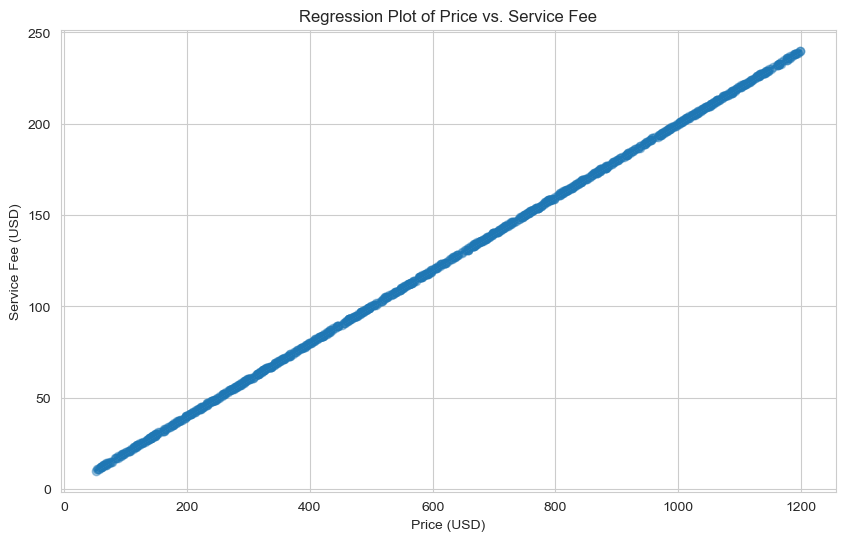


Question 8: Average Review Rate by Location and Room Type
Overall Average Review Rate: 3.28

Average Review Rate by Neighborhood Group and Room Type:
room_type            entire home/apt  hotel room  private room  shared room
neighbourhood_group                                                        
bronx                       3.345739         NaN      3.327400     3.264957
brookln                          NaN         NaN      4.000000          NaN
brooklyn                    3.249380        3.75      3.263931     3.337379
manhatan                         NaN         NaN      3.000000          NaN
manhattan                   3.275080        3.50      3.276814     3.256891
nan                         3.181818         NaN      3.222222          NaN
queens                      3.348815        3.75      3.314105     3.375691
staten island               3.327004         NaN      3.477419     3.533333


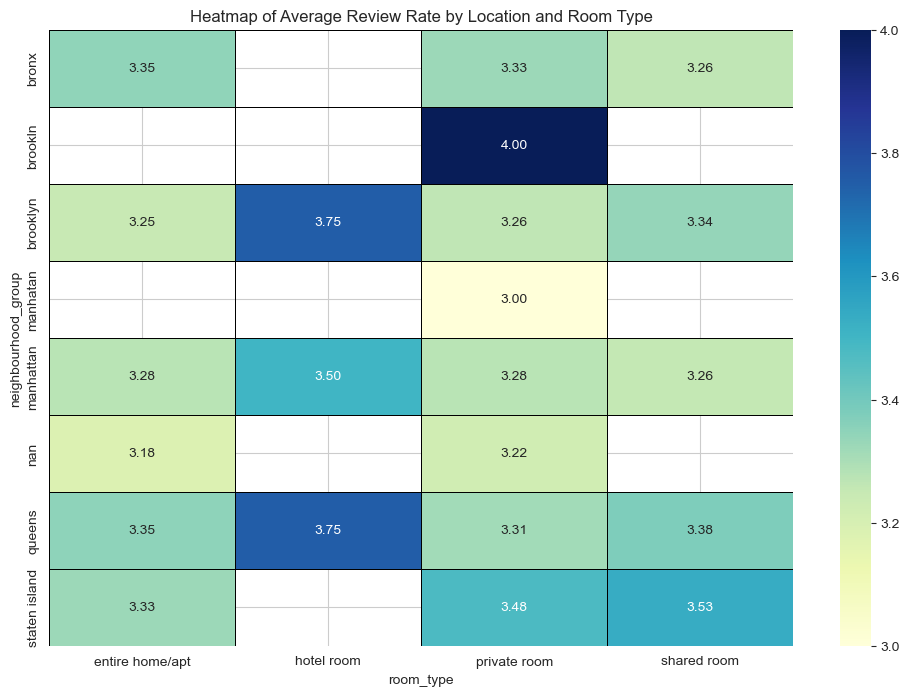

In [30]:
    # 7. Is there a correlation between the price of a listing and its service fee?
    print("\nQuestion 7: Correlation between Price and Service Fee")
    # Clean up non-numeric values in 'service_fee' for robust calculation
    df['service_fee'] = pd.to_numeric(df['service_fee'], errors='coerce')
    
    # Calculate correlation
    price_service_corr = df['price'].corr(df['service_fee'])
    print(f"Correlation between Price and Service Fee: {price_service_corr:.4f}")
    
    # Visualization for Question 7
    plt.figure(figsize=(10, 6))
    sns.regplot(x='price', y='service_fee', data=df.sample(n=1000, random_state=42), scatter_kws={'alpha':0.4}) # Sample 1000 points for plot efficiency
    plt.title('Regression Plot of Price vs. Service Fee')
    plt.xlabel('Price (USD)')
    plt.ylabel('Service Fee (USD)')
    plt.show()


    # 8. What is the average review rate number (e.g., stars) for listings, and does it vary based on the neighborhood group and room type?
    print("\nQuestion 8: Average Review Rate by Location and Room Type")
    
    # Average review rate overall
    overall_avg_review = df['review_rate_number'].mean()
    print(f"Overall Average Review Rate: {overall_avg_review:.2f}")

    # Average review rate by neighborhood group and room type
    avg_review_by_group_type = df.groupby(['neighbourhood_group', 'room_type'])['review_rate_number'].mean().unstack()
    print("\nAverage Review Rate by Neighborhood Group and Room Type:")
    print(avg_review_by_group_type)

    # Visualization for Question 8
    plt.figure(figsize=(12, 8))
    sns.heatmap(avg_review_by_group_type, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5, linecolor='black')
    plt.title('Heatmap of Average Review Rate by Location and Room Type')
    plt.show()


--- 4. Advanced Analysis (New Features) ---
Columns in DataFrame df: ['id', 'name', 'host_id', 'host_identity_verified', 'host_name', 'neighbourhood_group', 'neighbourhood', 'lat', 'long', 'country', 'country_code', 'instant_bookable', 'cancellation_policy', 'room_type', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'house_rules', 'license']

Feature 1: Geospatial Visualization (Price Distribution on Map)


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

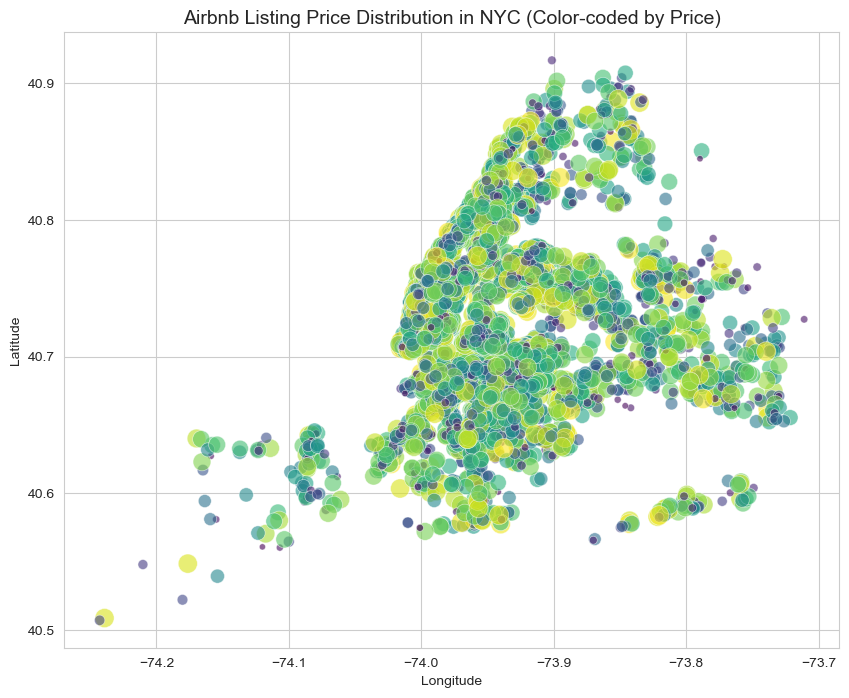

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame and is accessible

print("\n--- 4. Advanced Analysis (New Features) ---")
print("Columns in DataFrame df:", df.columns.tolist())
    
# Filter out extreme outliers for cleaner visualization (e.g., price above $2000)
# **CORRECTION APPLIED HERE: 'latitude' -> 'lat' and 'longitude' -> 'long'**
df_map = df[(df['price'] > 0) & (df['price'] < 2000) & (df['lat'].notna()) & (df['long'].notna())].copy()

print("\nFeature 1: Geospatial Visualization (Price Distribution on Map)")

# Create a scatter plot using latitude and longitude, with color representing price
plt.figure(figsize=(10, 8))
# We use a custom color map to better represent price differences
scatter = sns.scatterplot(
    # **CORRECTION APPLIED HERE: 'longitude' -> 'long' and 'latitude' -> 'lat'**
    x='long', 
    y='lat', 
    data=df_map.sample(n=10000, random_state=42), # Sample for efficiency and clarity
    hue='price', 
    palette=sns.color_palette("viridis", as_cmap=True), 
    size='price', 
    sizes=(20, 200), 
    alpha=0.6,
    legend=False
)

# Add labels and title
plt.title('Airbnb Listing Price Distribution in NYC (Color-coded by Price)', fontsize=14)
plt.xlabel('Longitude') # Note: The label text can remain 'Longitude' for readability
plt.ylabel('Latitude') # Note: The label text can remain 'Latitude' for readability

# Create a color bar legend for the price column
# The rest of the code is fine, as it uses 'price' and standard matplotlib/seaborn functions
norm = plt.Normalize(df_map['price'].min(), df_map['price'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
scatter.figure.colorbar(sm, label="Price (USD)")

plt.show()